In [40]:
# Data manipulation
# ==============================================================================
import pandas as pd
import numpy as np
from pathlib import Path

# DateTime
# ==============================================================================
import datetime as dt

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Sklearn
# ==============================================================================
from sklearn import preprocessing
from sklearn import model_selection
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [41]:
# Load the CSV file as a Pandas DataFrame and preview the DataFrame.
df = pd.read_csv(Path('../Working Resources/Cleaned_geographic_Data.csv'))

# Print shape and info of DataFrame.
print(df.shape)
print(df.info())

# Preview DataFrame.
df.head(10)

(2259, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2259 entries, 0 to 2258
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   GeoName      2259 non-null   object
 1   Description  2259 non-null   object
 2   2016         2259 non-null   int64 
 3   2017         2259 non-null   int64 
 4   2018         2259 non-null   int64 
 5   2019         2259 non-null   int64 
 6   2020         2259 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 123.7+ KB
None


,GeoName,Description,2016,2017,2018,2019,2020
0,Alabama (Metropolitan Portion),Wage and salary employment,1643706,1664641,1686588,1711156,1643053
1,Alabama (Metropolitan Portion),Proprietors employment Farm proprietors employ...,17653,17142,16771,16389,16466
2,Alabama (Metropolitan Portion),Proprietors employmentNonfarm proprietors empl...,423880,432197,447698,442971,428638
3,Alabama (Metropolitan Portion),Farm employment,21352,21534,20490,19416,19872
4,Alabama (Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,8693,7939,7353,7000,6494
5,Alabama (Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,11940,11334,11181,10875,10701
6,Alabama (Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,114882,116259,121459,125044,123120
7,Alabama (Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,174402,176320,178476,179351,172203
8,Alabama (Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,70131,69696,70679,70423,69298
9,Alabama (Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,226457,226733,226342,224842,217831


Keep the three industries most affected (Health , Education, Manufacturing) and least affected (IT, Finance, Professional, scientific, and technical services) during the Great Resignation.

In [42]:
# Print Description column.
print(df['Description'])

0                              Wage and salary employment
1       Proprietors employment Farm proprietors employ...
2       Proprietors employmentNonfarm proprietors empl...
3                                         Farm employment
4       Nonfarm employment Private nonfarm employment ...
                              ...                        
2254    Nonfarm employment Private nonfarm employment ...
2255    Government and government enterprises Federal ...
2256       Government and government enterprises Military
2257    Government and government enterprises State an...
2258    Government and government enterprises State an...
Name: Description, Length: 2259, dtype: object


In [43]:
new_keys = [
'Wage and salary employment', 
'Proprietors employment Farm proprietors employment',
'Proprietors employmentNonfarm proprietors employment 2/',
'Farm employment',
'Nonfarm employment Private nonfarm employment Mining, quarrying, and oil and gas extraction',
'Nonfarm employment Private nonfarm employment Utilities',
'Nonfarm employment Private nonfarm employment Construction',
'Nonfarm employment Private nonfarm employment Manufacturing',
'Nonfarm employment Private nonfarm employment Wholesale trade',
'Nonfarm employment Private nonfarm employment Retail trade',
'Nonfarm employment Private nonfarm employment Information',
'Nonfarm employment Private nonfarm employment Finance and insurance',
'Nonfarm employment Private nonfarm employment Real estate and rental and leasing',
'Nonfarm employment Private nonfarm employment Professional, scientific, and technical services',
'Nonfarm employment Private nonfarm employment Management of companies and enterprises',
'Nonfarm employment Private nonfarm employment Administrative and support and waste management and remediation services',
'Nonfarm employment Private nonfarm employment Educational services',
'Nonfarm employment Private nonfarm employment Health care and social assistance',
'Nonfarm employment Private nonfarm employment Arts, entertainment, and recreation',
'Nonfarm employment Private nonfarm employment Accommodation and food services',
'Nonfarm employment Private nonfarm employment Other services (except government and government enterprises)',
'Government and government enterprises Federal civilian',
'Government and government enterprises Military',
'Government and government enterprises State and local State government',
'Government and government enterprises State and local Local government',
]

new_names = [
'- Wage and salary employment', 
'- Proprietors employment Farm proprietors employment',
'- Proprietors employmentNonfarm proprietors employment 2/',
'- Farm employment',
'- Nonfarm employment Private nonfarm employment Mining, quarrying, and oil and gas extraction',
'- Nonfarm employment Private nonfarm employment Utilities',
'- Nonfarm employment Private nonfarm employment Construction',
'Nonfarm employment Private nonfarm employment Manufacturing',
'- Nonfarm employment Private nonfarm employment Wholesale trade',
'- Nonfarm employment Private nonfarm employment Retail trade',
'Nonfarm employment Private nonfarm employment Information',
'Nonfarm employment Private nonfarm employment Finance and insurance',
'- Nonfarm employment Private nonfarm employment Real estate and rental and leasing',
'Nonfarm employment Private nonfarm employment Professional, scientific, and technical services',
'- Nonfarm employment Private nonfarm employment Management of companies and enterprises',
'- Nonfarm employment Private nonfarm employment Administrative and support and waste management and remediation services',
'Nonfarm employment Private nonfarm employment Educational services',
'Nonfarm employment Private nonfarm employment Health care and social assistance',
'- Nonfarm employment Private nonfarm employment Arts, entertainment, and recreation',
'- Nonfarm employment Private nonfarm employment Accommodation and food services',
'- Nonfarm employment Private nonfarm employment Other services (except government and government enterprises)',
'- Government and government enterprises Federal civilian',
'- Government and government enterprises Military',
'- Government and government enterprises State and local State government',
'- Government and government enterprises State and local Local government',
]

In [44]:
new_names2 = []
for i in range(len(new_names)):
    if new_names[i][0:2] != '- ':
        new_names2.append(new_names[i])
    else:
        new_names2.append('0')
        
new_names2

['0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 'Nonfarm employment Private nonfarm employment Manufacturing',
 '0',
 '0',
 'Nonfarm employment Private nonfarm employment Information',
 'Nonfarm employment Private nonfarm employment Finance and insurance',
 '0',
 'Nonfarm employment Private nonfarm employment Professional, scientific, and technical services',
 '0',
 '0',
 'Nonfarm employment Private nonfarm employment Educational services',
 'Nonfarm employment Private nonfarm employment Health care and social assistance',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0']

In [45]:
repl = {x:y for [x, y ] in zip(new_keys, new_names2)}

In [46]:
df = df.replace(repl)
df.head()

,GeoName,Description,2016,2017,2018,2019,2020
0,Alabama (Metropolitan Portion),0,1643706,1664641,1686588,1711156,1643053
1,Alabama (Metropolitan Portion),0,17653,17142,16771,16389,16466
2,Alabama (Metropolitan Portion),0,423880,432197,447698,442971,428638
3,Alabama (Metropolitan Portion),0,21352,21534,20490,19416,19872
4,Alabama (Metropolitan Portion),0,8693,7939,7353,7000,6494


In [47]:
df2 = df[df['Description'] != '0']

df2

,GeoName,Description,2016,2017,2018,2019,2020
7,Alabama (Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,174402,176320,178476,179351,172203
10,Alabama (Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,23733,24106,24419,24201,22325
11,Alabama (Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,96244,97731,100114,97570,98867
13,Alabama (Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,132024,136100,140652,142288,143286
16,Alabama (Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,36130,36651,35850,36894,34253
...,...,...,...,...,...,...,...
2246,Wyoming (Nonmetropolitan Portion) *,Nonfarm employment Private nonfarm employment ...,8535,8483,8891,9014,8315
2247,Wyoming (Nonmetropolitan Portion) *,Nonfarm employment Private nonfarm employment ...,2809,2845,2847,2714,2534
2248,Wyoming (Nonmetropolitan Portion) *,Nonfarm employment Private nonfarm employment ...,10881,11025,11702,11824,11356
2250,Wyoming (Nonmetropolitan Portion) *,Nonfarm employment Private nonfarm employment ...,11592,11766,12490,12866,12570


In [48]:
# Determine value counts on GeoName column.
df2['GeoName'].value_counts()

Kansas (Metropolitan Portion)               8
Nebraska (Metropolitan Portion)             8
Texas (Metropolitan Portion)                8
Iowa (Metropolitan Portion)                 8
South Carolina (Metropolitan Portion)       8
                                           ..
Utah (Nonmetropolitan Portion) *            3
Louisiana (Nonmetropolitan Portion) *       3
Oklahoma (Nonmetropolitan Portion) *        2
South Dakota (Nonmetropolitan Portion) *    2
Maryland (Nonmetropolitan Portion) *        1
Name: GeoName, Length: 97, dtype: int64

In [49]:
# Split GeoName. 
df2[['State', 'GeoName']] = df2['GeoName'].str.split('(', expand=True)

df2.head()

/Users/gustavosanchez/opt/anaconda3/envs/GreatRes/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,GeoName,Description,2016,2017,2018,2019,2020,State
7,Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,174402,176320,178476,179351,172203,Alabama
10,Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,23733,24106,24419,24201,22325,Alabama
11,Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,96244,97731,100114,97570,98867,Alabama
13,Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,132024,136100,140652,142288,143286,Alabama
16,Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,36130,36651,35850,36894,34253,Alabama


In [50]:
# Reorder of columns in DataFrame. 
df3 = df2[['State', 'GeoName', 'Description', '2016', '2017', '2018', '2019', '2020']]
df3

,State,GeoName,Description,2016,2017,2018,2019,2020
7,Alabama,Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,174402,176320,178476,179351,172203
10,Alabama,Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,23733,24106,24419,24201,22325
11,Alabama,Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,96244,97731,100114,97570,98867
13,Alabama,Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,132024,136100,140652,142288,143286
16,Alabama,Metropolitan Portion),Nonfarm employment Private nonfarm employment ...,36130,36651,35850,36894,34253
...,...,...,...,...,...,...,...,...
2246,Wyoming,Nonmetropolitan Portion) *,Nonfarm employment Private nonfarm employment ...,8535,8483,8891,9014,8315
2247,Wyoming,Nonmetropolitan Portion) *,Nonfarm employment Private nonfarm employment ...,2809,2845,2847,2714,2534
2248,Wyoming,Nonmetropolitan Portion) *,Nonfarm employment Private nonfarm employment ...,10881,11025,11702,11824,11356
2250,Wyoming,Nonmetropolitan Portion) *,Nonfarm employment Private nonfarm employment ...,11592,11766,12490,12866,12570


In [51]:
# Replace values with '0'(Metropolitan Portion) and '1'(Nonmetropolitan Portion).
df3['GeoName'].replace(['Metropolitan Portion)', 'Nonmetropolitan Portion) *'], [0, 1], inplace= True)

# Display.
df3

/Users/gustavosanchez/opt/anaconda3/envs/GreatRes/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,State,GeoName,Description,2016,2017,2018,2019,2020
7,Alabama,0,Nonfarm employment Private nonfarm employment ...,174402,176320,178476,179351,172203
10,Alabama,0,Nonfarm employment Private nonfarm employment ...,23733,24106,24419,24201,22325
11,Alabama,0,Nonfarm employment Private nonfarm employment ...,96244,97731,100114,97570,98867
13,Alabama,0,Nonfarm employment Private nonfarm employment ...,132024,136100,140652,142288,143286
16,Alabama,0,Nonfarm employment Private nonfarm employment ...,36130,36651,35850,36894,34253
...,...,...,...,...,...,...,...,...
2246,Wyoming,1,Nonfarm employment Private nonfarm employment ...,8535,8483,8891,9014,8315
2247,Wyoming,1,Nonfarm employment Private nonfarm employment ...,2809,2845,2847,2714,2534
2248,Wyoming,1,Nonfarm employment Private nonfarm employment ...,10881,11025,11702,11824,11356
2250,Wyoming,1,Nonfarm employment Private nonfarm employment ...,11592,11766,12490,12866,12570


In [53]:
# Data preparation
# ==============================================================================
df3 = df3.rename(columns={'GeoName': 'GeoName Encoding','Description': 'Industry Description'})
df3 = df3.sort_index()
df3.head(10)

,State,GeoName Encoding,Industry Description,2016,2017,2018,2019,2020
7,Alabama,0,Nonfarm employment Private nonfarm employment ...,174402,176320,178476,179351,172203
10,Alabama,0,Nonfarm employment Private nonfarm employment ...,23733,24106,24419,24201,22325
11,Alabama,0,Nonfarm employment Private nonfarm employment ...,96244,97731,100114,97570,98867
13,Alabama,0,Nonfarm employment Private nonfarm employment ...,132024,136100,140652,142288,143286
16,Alabama,0,Nonfarm employment Private nonfarm employment ...,36130,36651,35850,36894,34253
17,Alabama,0,Nonfarm employment Private nonfarm employment ...,200843,204263,207762,213194,206243
32,Alabama,1,Nonfarm employment Private nonfarm employment ...,96790,97795,99118,99899,95912
35,Alabama,1,Nonfarm employment Private nonfarm employment ...,3355,3383,3262,3141,3009
36,Alabama,1,Nonfarm employment Private nonfarm employment ...,15159,14934,15410,14901,14990
38,Alabama,1,Nonfarm employment Private nonfarm employment ...,13435,13762,14710,14515,14336


Train dates : 7 --- 2205  (n=589)
Test dates  : 2207 --- 2252  (n=12)


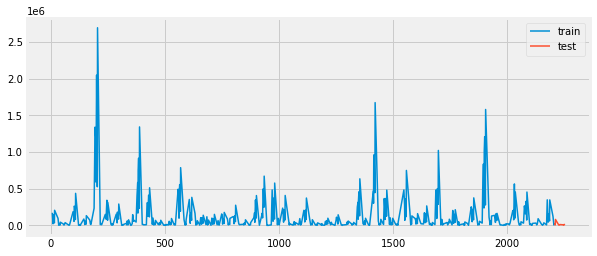

In [59]:
# Split data into train-test
# ==============================================================================
steps = 12
df3_train = df3[:-steps]
df3_test  = df3[-steps:]

print(f"Train dates : {df3_train.index.min()} --- {df3_train.index.max()}  (n={len(df3_train)})")
print(f"Test dates  : {df3_test.index.min()} --- {df3_test.index.max()}  (n={len(df3_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
df3_train['2020'].plot(ax=ax, label='Train Year')
df3_test['2020'].plot(ax=ax, label='Test Year')
ax.legend();

In [61]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=df3_train['2020'])
forecaster

/Users/gustavosanchez/opt/anaconda3/envs/GreatRes/lib/python3.7/site-packages/skforecast/utils/utils.py:371: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'
/Users/gustavosanchez/opt/anaconda3/envs/GreatRes/lib/python3.7/site-packages/skforecast/utils/utils.py:371: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  '`y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.'


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 588] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-11-09 12:20:24 
Last fit date: 2022-11-09 12:20:25 
Skforecast version: 0.5.1 
Python version: 3.7.13 

## Determining which variable to predict. Y (dependent) variable and X (independent) variables.

In [13]:
# # Separate target values.
# y = df3['2020']
# X = df3.drop('2020', axis=1)

In [14]:
# # Identify X parameter.
# X = pd.get_dummies(data= X, columns=['State', 'Description'])

# # Print the shape of X.
# print(X.shape)

# # Display preprocessed machine learning dataframe to model.
# X.head()

(601, 64)


,GeoName,2016,2017,2018,2019,State_Alabama,State_Alaska,State_Arizona,State_Arkansas,State_California,...,State_Wisconsin,State_Wyoming,Description_Nonfarm employment Private nonfarm employment Educational services,Description_Nonfarm employment Private nonfarm employment Finance and insurance,"Description_Nonfarm employment Private nonfarm employment Forestry, fishing, and related activities",Description_Nonfarm employment Private nonfarm employment Health care and social assistance,Description_Nonfarm employment Private nonfarm employment Information,Description_Nonfarm employment Private nonfarm employment Manufacturing,"Description_Nonfarm employment Private nonfarm employment Professional, scientific, and technical services",Description_Nonfarm employment Private nonfarm employment Transportation and warehousing
7,0,174402,176320,178476,179351,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10,0,23733,24106,24419,24201,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
11,0,96244,97731,100114,97570,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
13,0,132024,136100,140652,142288,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
16,0,36130,36651,35850,36894,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [15]:
# # Drop Transportation and Warehousing column.
# X = X.drop(['Description_Nonfarm employment Private nonfarm employment Transportation and warehousing'], axis=1)

# # Display
# X

,GeoName,2016,2017,2018,2019,State_Alabama,State_Alaska,State_Arizona,State_Arkansas,State_California,...,State_West Virginia,State_Wisconsin,State_Wyoming,Description_Nonfarm employment Private nonfarm employment Educational services,Description_Nonfarm employment Private nonfarm employment Finance and insurance,"Description_Nonfarm employment Private nonfarm employment Forestry, fishing, and related activities",Description_Nonfarm employment Private nonfarm employment Health care and social assistance,Description_Nonfarm employment Private nonfarm employment Information,Description_Nonfarm employment Private nonfarm employment Manufacturing,"Description_Nonfarm employment Private nonfarm employment Professional, scientific, and technical services"
7,0,174402,176320,178476,179351,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10,0,23733,24106,24419,24201,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11,0,96244,97731,100114,97570,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
13,0,132024,136100,140652,142288,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16,0,36130,36651,35850,36894,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2246,1,8535,8483,8891,9014,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2247,1,2809,2845,2847,2714,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2248,1,10881,11025,11702,11824,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2250,1,11592,11766,12490,12866,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [16]:
# # Split our data into training and testing.
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=66)

In [17]:
# # Determine the shape of our training and testing sets.
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

(450, 63)
(151, 63)
(450,)
(151,)


In [18]:
# # Scale testing Data. 
# X_train_scaled = StandardScaler().fit(X_train).transform(X_train)

In [19]:
# X_train_scaled[:5]

array([[ 1.20789751, -0.44091246, -0.44119228, -0.4393014 , -0.4422669 ,
        -0.12570344, -0.14285714, -0.15075567,  6.63324958, -0.13453456,
        -0.15829386, -0.16552118, -0.12570344, -0.11624764, -0.13453456,
        -0.14285714, -0.17247691, -0.13453456, -0.14285714, -0.15829386,
        -0.17247691, -0.13453456, -0.17247691, -0.12570344, -0.15075567,
        -0.11624764, -0.14285714, -0.14285714, -0.13453456, -0.11624764,
        -0.15829386, -0.14285714, -0.14285714, -0.14285714, -0.13453456,
        -0.11624764, -0.11624764, -0.14285714, -0.15075567, -0.09470274,
        -0.13453456, -0.13453456, -0.14285714, -0.17247691, -0.08192319,
        -0.14285714, -0.11624764, -0.14285714, -0.16552118, -0.12570344,
        -0.11624764, -0.15075567, -0.16552118, -0.15075567, -0.16552118,
        -0.13453456, -0.34956332,  2.39090316, -0.23735633, -0.40347329,
        -0.39599538, -0.4145781 , -0.38083877],
       [ 1.20789751, -0.36442623, -0.36592501, -0.36503068, -0.36650977,
   

In [20]:
# Verify the mean and standard deviation.
print(np.mean(X_train_scaled[:,0]))
print(np.std(X_train_scaled[:,0]))

-8.68441121484567e-17
1.0


## Decision Tree Regressor 

In [21]:
# dtree = DecisionTreeRegressor(max_depth= 10, min_samples_leaf= 0.13, random_state= 3)
# dtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=0.13, random_state=3)

In [22]:
# # Code 2 to 4
# pred_train_tree= dtree.predict(X_train)
# print(np.sqrt(mean_squared_error(y_train,pred_train_tree)))
# print(r2_score(y_train, pred_train_tree))
# # Code lines 6 to 8
# pred_test_tree= dtree.predict(X_test)
# print(np.sqrt(mean_squared_error(y_test,pred_test_tree))) 
# print(r2_score(y_test, pred_test_tree))

156411.4929507185
0.5765248990262687
161436.0221402629
0.6298044499440351


In [23]:
# # Fit the regression tree 'dtree1' and 'dtree2' 
# dtree1 = DecisionTreeRegressor(max_depth=2)
# dtree2 = DecisionTreeRegressor(max_depth=5)
# dtree1.fit(X_train, y_train)
# dtree2.fit(X_train, y_train)

# # Predict on training data
# tr1 = dtree1.predict(X_train)
# tr2 = dtree2.predict(X_train) 

# # Predict on testing data
# y1 = dtree1.predict(X_test)
# y2 = dtree2.predict(X_test)

In [24]:
# # Print RMSE and R-squared value for regression tree 'dtree1' on training data
# print(np.sqrt(mean_squared_error(y_train,tr1))) 
# print(r2_score(y_train, tr1))

# # Print RMSE and R-squared value for regression tree 'dtree1' on testing data
# print(np.sqrt(mean_squared_error(y_test,y1))) 
# print(r2_score(y_test, y1))

72812.47593866003
0.9082296990684319
105160.4984279411
0.8429146911990535


## Random Forest Regressor

In [25]:
# #Random Forest Model
# model_rf = RandomForestRegressor(n_estimators=5000, oob_score=True, random_state=100)
# model_rf.fit(X_train, y_train) 
# pred_train_rf= model_rf.predict(X_train)

# print(np.sqrt(mean_squared_error(y_train,pred_train_rf)))
# print(r2_score(y_train, pred_train_rf))

# pred_test_rf = model_rf.predict(X_test)
# print(np.sqrt(mean_squared_error(y_test,pred_test_rf)))
# print(r2_score(y_test, pred_test_rf))
# print(mean_squared_error(y_test,pred_test_rf))

17883.936864327432
0.9944637357202724
26028.90278298681
0.9903763012231802
677503780.0861785


In [26]:
# print(y_test, pred_test_rf)

1671      3071
1994      5137
1550    276185
378     405722
1002     29239
         ...  
706      99570
130       1635
385     915752
1558    749150
2031    565090
Name: 2020, Length: 151, dtype: int64 [2.88203500e+03 4.97534160e+03 2.41637016e+05 3.94827038e+05
 2.92581544e+04 4.72367186e+05 1.55203002e+06 1.96897014e+04
 1.70044544e+04 1.29252669e+05 3.25688280e+03 8.86327974e+04
 3.91081160e+03 6.63536660e+03 1.31423000e+04 1.34303234e+04
 2.33960784e+04 1.93134258e+04 1.16520632e+04 1.32836590e+06
 2.53514300e+03 1.86514302e+04 6.05599980e+03 1.77008149e+05
 5.34803340e+03 3.64924104e+05 1.01602099e+05 3.19354234e+04
 1.15928119e+06 7.77035334e+04 1.54209500e+04 1.50836001e+05
 9.70760062e+04 4.52980820e+03 1.56408474e+05 1.29628457e+06
 3.16745324e+04 1.77496728e+04 8.40028060e+03 2.23583592e+05
 4.25809570e+04 7.00525040e+03 6.03161160e+03 2.94553114e+04
 3.61213800e+02 9.98131974e+04 1.01015255e+05 1.05140085e+05
 6.39061820e+03 4.01615022e+05 7.25507992e+05 1.14382164e+04
 1.2